In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import norm

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from main_code.utils.constants import *
from main_code.utils.functions import *
from main_code.utils.CosmoFunc import *

pvhub_dir = os.environ.get('PVHUB_DIR_PATH')
if not pvhub_dir in sys.path: sys.path.append(pvhub_dir)
from pvhub import * # type: ignore

r-band magnitude corresponding to J-band magnitude of 13.65 = 15.28
Number of galaxies with 2MASS counterpart in this new magnitude-limited sample =  4070


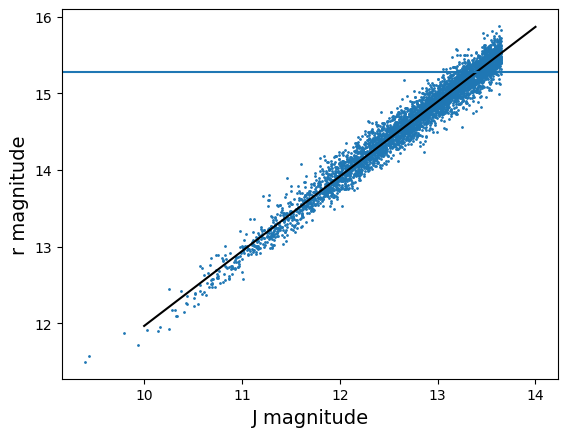

In [8]:
# Load Cullan's data
df_h22 = pd.read_csv("../../data/external/h22/SDSS_PV_public.dat", delim_whitespace=True)

# Apply the same redshift cut as mine and add 'SDSS' prefix
df_h22 = df_h22[(df_h22['zcmb_group'] >= ZMIN) & (df_h22['zcmb_group'] <= ZMAX)]
df_h22['objid'] = df_h22['objid'].apply(lambda x: 'SDSS' + str(x))

# Load my SDSS
df_sdss = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")[["objid", "j_m_ext", "extinction_j"]]

# Merge Cullan's SDSS and mine
df = df_h22.merge(df_sdss, on="objid", how="left")

# Add flag column for rows with 2MASS counterpart
df["has_counterpart"] = ~df["j_m_ext"].isna()

# Calculate extinction-corrected magnitudes
df["mag_r"] = df["deVMag_r"] - df["extinction_r"]
df["mag_j"] = df["j_m_ext"] - df["extinction_j"]

# Fit a linear curve
df_ = df.copy()
df_ = df_[df_["has_counterpart"] == True]
popt, pcov = curve_fit(linear_func, df_["mag_j"].to_numpy(), df_["mag_r"].to_numpy(), p0=[1.0, -2.0])

# Plot r vs J magnitude
plt.scatter(df_["mag_j"], df_["mag_r"], s=1)
plt.xlabel("J magnitude", fontsize=14)
plt.ylabel("r magnitude", fontsize=14)

# Plot the relation
x_ = np.linspace(10, 14, 100)
y_ = linear_func(x_, *popt)
plt.plot(x_, y_, c='k')

# Calculate r magnitude at J magnitude of 13.65
r_mag_lim = 15.28 #linear_func(13.65, *popt)
plt.axhline(r_mag_lim)
print(f"r-band magnitude corresponding to J-band magnitude of 13.65 = {round(r_mag_lim, 2)}")

# Select galaxies with that limiting r-magnitude (add new flag)
df["new_sample"] = (df["deVMag_r"] - df["extinction_r"]) <= r_mag_lim

# Also apply redshift cut
df = df[df["zcmb_group"] <= ZMAX]

print("Number of galaxies with 2MASS counterpart in this new magnitude-limited sample = ", df["new_sample"].sum())